In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [5]:
def load_star_params(star_table_path, FeH=0.0, aM=0.0):
    """
    Load one of SP's tables. Does not include metalicty and FeH, will proabaly need my own table.
    """
    data = Table.read(star_table_path, format ='ascii')[0]
    mass, radius = data['Mass__0'] * u.M_sun, data['Radius__0'] * u.Rsun
    g_star = (const.G * mass) / radius**2
    logg = np.log10((g_star.to(u.cm/u.s**2)).value)
    star_params = {'Teff':data['Teff__0'], 'logg': logg, 'FeH': FeH, 'aM': aM, 'radius':data['Radius__0'] * u.Rsun, 'distance':data['Distance__0']*u.pc }
    return star_params

In [6]:
star_params = load_star_params('../GJ_699_ParamStats.txt')
star_params

{'Teff': 3222.6267,
 'logg': 5.099468009663126,
 'FeH': 0.0,
 'aM': 0.0,
 'radius': <Quantity 0.18711261 solRad>,
 'distance': <Quantity 1.8266406 pc>}

In [13]:
import lzma
def unzip_file(filepath):
    """
    Moving the lzma work to a separate directory
    """
    nameout = filepath[:-3]
    with lzma.open(filepath) as f, open(filepath, 'wb') as fout: #https://stackoverflow.com/a/33718185
        file_content = f.read()
        fout.write(file_content)
    return nameout

In [16]:
"""Spectra = glob.glob('lyon_files/*spec.7.')
npSpectra = []
for sp in Spectra:
    nameout = unzip_file(sp)
    npSpectra.append(nameout)
npSpectra"""

"Spectra = glob.glob('lyon_files/*spec.7.')\nnpSpectra = []\nfor sp in Spectra:\n    nameout = unzip_file(sp)\n    npSpectra.append(nameout)\nnpSpectra"

In [18]:
npSpectra = glob.glob('lyon_files/*spec.7')
npSpectra

['lyon_files/lte032.0-5.0-0.0a+0.0.BT-Settl.spec.7',
 'lyon_files/lte032.0-5.5-0.0a+0.0.BT-Settl.spec.7',
 'lyon_files/lte033.0-5.0-0.0a+0.0.BT-Settl.spec.7',
 'lyon_files/lte033.0-5.5-0.0a+0.0.BT-Settl.spec.7']

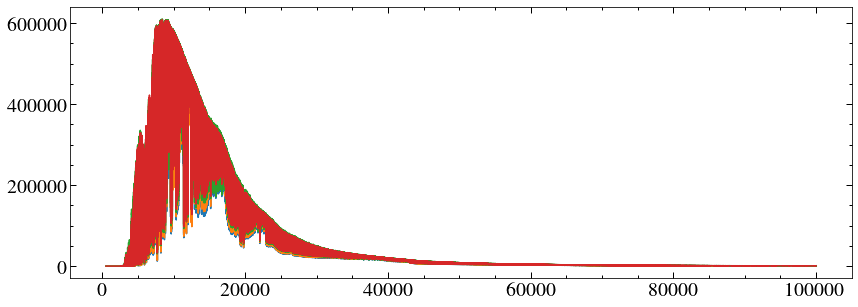

In [19]:
wavemin=500, # in angstroms
wavemax=100000
DF = -8.

ts = [3200.0, 3200.0, 3300.0, 3300.0]
gs = [5.0, 5.5, 5.5, 5.0]
waves = []
fluxes = []
spectra = []
for i, sp in enumerate(npSpectra):
    #params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0}
    phoenixR = ascii.read(sp,format="fixed_width_no_header",col_starts=(0,14),col_ends=(12,25),delimiter=" ",names=('Wave','Spec'))
    #print(len(phoenixR['Wave']))
    ph1, jj = np.unique(np.array(phoenixR['Wave']),return_index=True)
    phoenix = np.zeros((len(ph1),2))
    for kk in range(len(jj)):
        phoenix[kk,1] = np.float64(phoenixR['Spec'][jj[kk]].replace("D","E"))
    phoenix[:,0] = ph1
    ind = np.where( (phoenix[:,0] <= wavemax) & (phoenix[:,0] >= wavemin))[0]  
    xraw = phoenix[ind,0]
    yraw = np.power(10.,phoenix[ind,1] + DF)#.tolist()
    waves.append(xraw)
    fluxes.append(yraw)
   # params.update({'flux':yraw})
   # spectra.append(params)
   # print(len(params['flux']))
    #plt.plot(xraw, params['flux'])

nwave = np.min([len(w) for w in waves])
for w in waves:
    if len(w) == nwave:
        wav = w

for i, sp in enumerate(npSpectra):
    flux = fluxes[i]
    if len(waves[i]) > nwave:
        print(np.trapz(flux, waves[i]))
        flux = interp1d(waves[i], flux, fill_value='extrapolate')(wav)
        print(np.trapz(flux, wav))
            #wav = waves[i]
    params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0, 'flux': flux}
    spectra.append(params)
    plt.plot(wav, params['flux'])

{'Teff': 3222.6267, 'logg': 5.099468009663126, 'FeH': 0.0, 'aM': 0.0, 'radius': <Quantity 0.18711261 solRad>, 'distance': <Quantity 1.8266406 pc>}
[[3200.0, 5.0], [3200.0, 5.5], [3300.0, 5.5], [3300.0, 5.0]]
[3222.6267, 5.099468009663126]
<class 'list'>
<class 'list'>
[array([5.17130318e-48, 5.24082913e-48, 5.31251293e-48, ...,
       5.24686633e+02, 5.59113528e+02, 5.91153139e+02]), array([6.87068440e-47, 6.96305780e-47, 7.05504844e-47, ...,
       5.41626619e+02, 5.65457541e+02, 5.85194182e+02]), array([9.66273346e-46, 9.78588257e-46, 9.91060119e-46, ...,
       5.52968000e+02, 5.86273143e+02, 6.16595002e+02]), array([3.39781712e-44, 3.44032919e-44, 3.48337315e-44, ...,
       5.68852931e+02, 5.92379472e+02, 6.11786656e+02])]


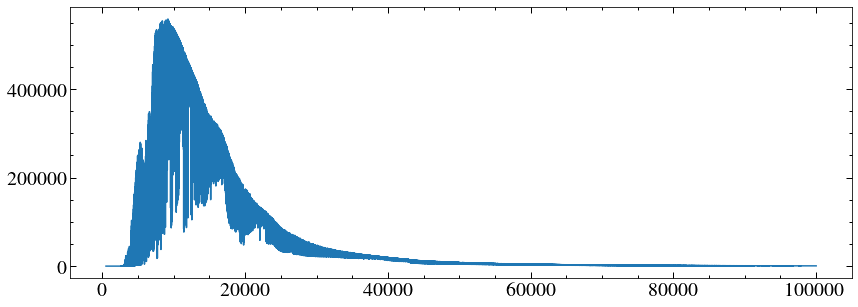

In [21]:
from scipy.interpolate import griddata, interp1d



def interp_flux(spectra, params_to_interp, star_params):
    """
    build the new spectrum
    """
    out_vals = [star_params[p] for p in params_to_interp]
    in_vals = [[s[p] for p in params_to_interp] for s in spectra]
    fluxes = [(s['flux']) for s in spectra]
    #fluxes = [np.random.random(100) for s in spectra]
   # print(type(fluxes[0]))
    if len(params_to_interp) == 1:
        in_vals = [s[params_to_interp[0]] for s in spectra]
        new_flux = interp1d(in_vals, fluxes, axis=0, fill_value='extrapolate')(star_params[params_to_interp[0]])
    else:
     #   out_vals = [star_params[p] for p in params_to_interp]
        in_vals = [[s[p] for p in params_to_interp] for s in spectra]
        print(in_vals)
        print(out_vals)
        print(type(in_vals))
        print(type(out_vals))
        print(fluxes)
        new_flux = griddata(in_vals, fluxes, out_vals)[0]
    return new_flux

star_params = star_params
print(star_params)
params_to_interp = ['Teff', 'logg']
nflux = interp_flux(spectra, params_to_interp, star_params)
nwave = wav
plt.plot(nwave, nflux)

In [22]:
savedat = Table([nwave*u.AA, nflux*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX'])
ascii.write(savedat, '../phoenix_repo/lyon_phoenix_3222_5.1_10um.ecsv', format='ecsv', overwrite=True)

In [12]:
path = '/home/david/work/muscles/MegaMUSCLES/GJ_699/HST/STIS/'
g430lpath = glob.glob(path+'*sx1.fits')
odata = fits.getdata(g430lpath[0],1)[0]
wo, fo, eo, dq = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR'], odata['DQ']
wo, fo, eo = wo[dq==0], fo[dq==0], eo[dq==0]
#plt.step(odata['WAVELENGTH'], odata['FLUX'], where='mid')

In [5]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [13]:
phx = Table.read('../test_files/components/hlsp_muscles_model_phx_gj699_na_v2_component-spec.ecsv')
pw, pf = phx['WAVELENGTH'], phx['FLUX']
pscale = phx.meta['NORMFAC']
pf *= pscale

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

pwr, pfr = smear(pwi, pfi,250)

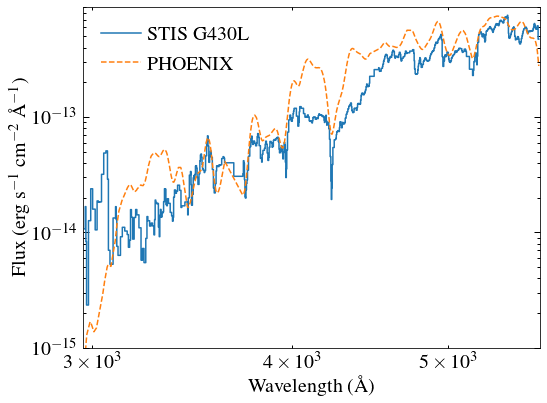

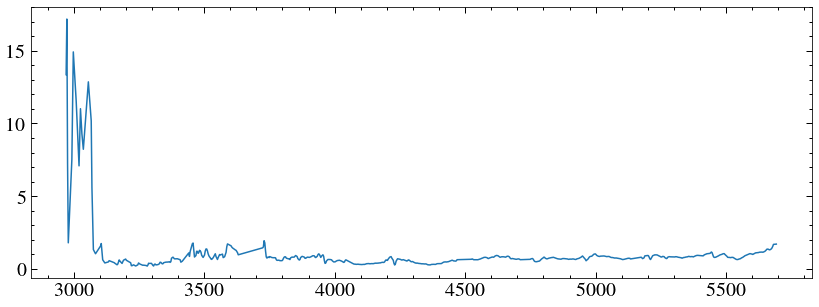

In [18]:
plt.figure(figsize=(8,6))
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.5e-13, 9e-13)
fob = convolve(fo,Box1DKernel(2))
eob = convolve(eo,Box1DKernel(2))/(2**0.5)
plt.step(wo, fob, where='mid', label='STIS G430L', c ='C0')#, alpha = 0.5)
#fob, eob = fob/photscale, eob/photscale
#plt.step(wo, fob, where='mid', label='Scaled STIS G430L', c='C0')
plt.plot(pwr, pfr, ls ='--', c='C1', label = 'PHOENIX')
plt.legend()
plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1e-14)
plt.tight_layout()
plt.show()
plt.plot(wo, fob/pfr)